# IEEE Fraud Detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

sns.set_theme()

## 1 - Carregando os datasets

In [4]:
df_train_id = pd.read_csv("train_identity.csv")
df_train_tr = pd.read_csv("train_transaction.csv")
df_test_id = pd.read_csv("test_identity.csv")
df_test_tr = pd.read_csv("train_transaction.csv")

In [7]:
df_train_id.shape, df_train_tr.shape, df_test_id.shape, df_test_tr.shape

((144233, 41), (590540, 394), (141907, 41), (590540, 394))

In [8]:
df_train = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')
df_test = pd.merge(df_test_tr, df_test_id, on='TransactionID', how='left')

In [9]:
print(df_train.shape)
print(df_test.shape)

(590540, 434)
(590540, 434)


In [10]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [11]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Variável alvo
target = df_train['isFraud'].value_counts()
target

0    569877
1     20663
Name: isFraud, dtype: int64

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


## 2 - Análise Exploratória

### Transaction Amount

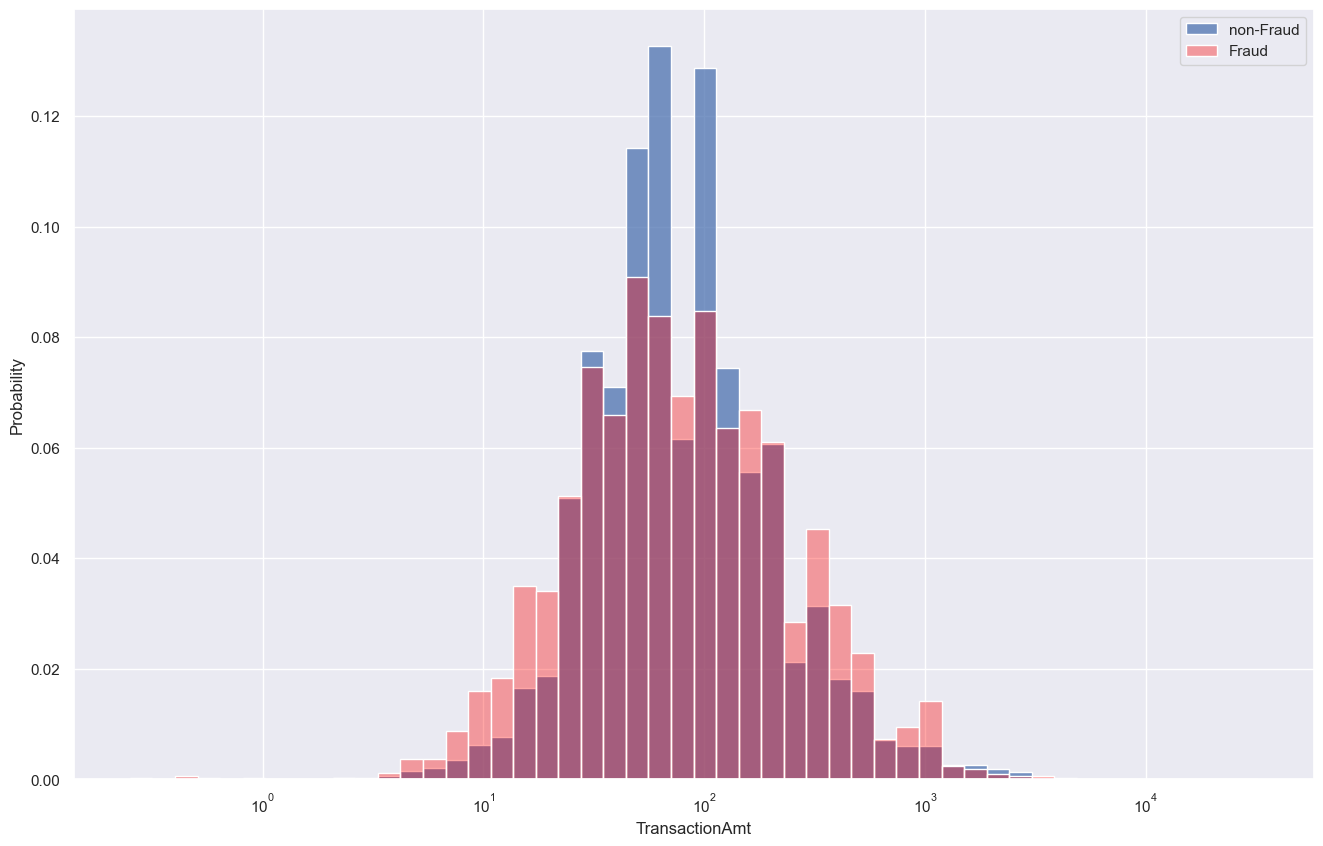

In [14]:
bins = np.histogram_bin_edges(np.log10(df_train['TransactionAmt']), bins=50)

plt.figure(figsize=(16,10))

# plt.subplot(121)
px = sns.histplot(data=df_train, x='TransactionAmt', label='non-Fraud',
                  bins=bins, stat='probability', log_scale=True)


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True], x='TransactionAmt', bins=bins,
                   stat='probability', log_scale=True, color='red', alpha=0.35, label='Fraud')


plt.legend()
plt.show()

### TransactionDT

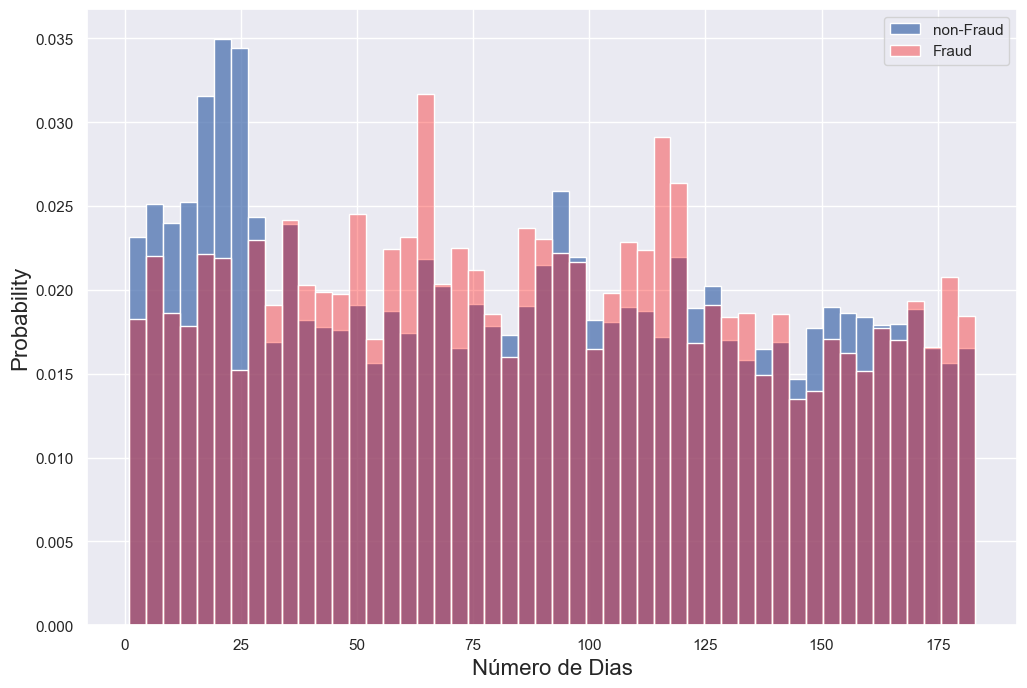

In [15]:
bins = np.histogram_bin_edges(df_train['TransactionDT'] / 86400, bins=50)

fig = plt.figure(figsize=(12,8))

# plt.subplot(121)
px = sns.histplot(data=df_train['TransactionDT'] / 86400, label='non-Fraud',
                  bins=bins, stat='probability')


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True]['TransactionDT'] / 86400, bins=bins,
                   stat='probability', color='red', alpha=0.35, label='Fraud')

px2.set_xlabel('Número de Dias', fontsize=16)
px2.set_ylabel('Probability', fontsize=16)
plt.legend()
plt.show()

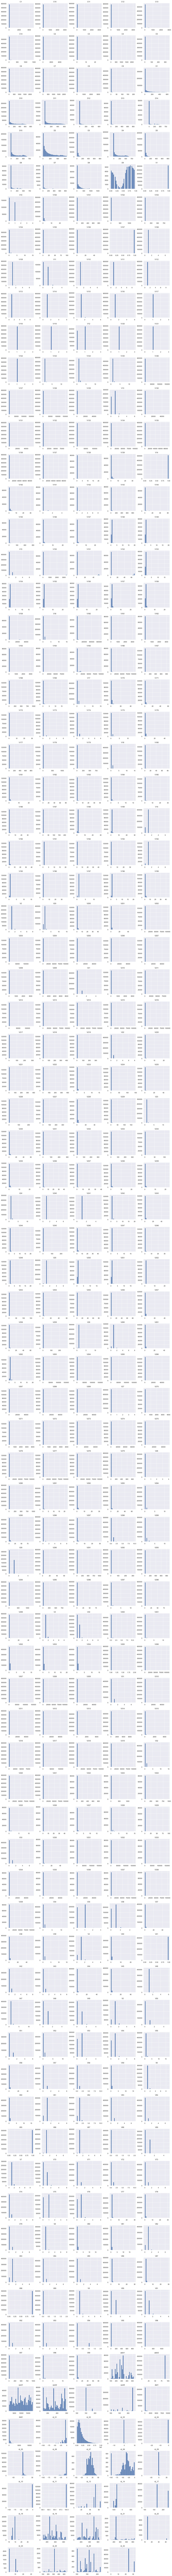

In [16]:
df_train[df_train.columns.difference(['TransactionID', 'TransactionDT', 'isFraud', 'TransactionAmt'])].hist(figsize=(20,348), layout=(87, 5), bins=30);

#### Avaliando o tipo de aparelho em que a transação foi realizada

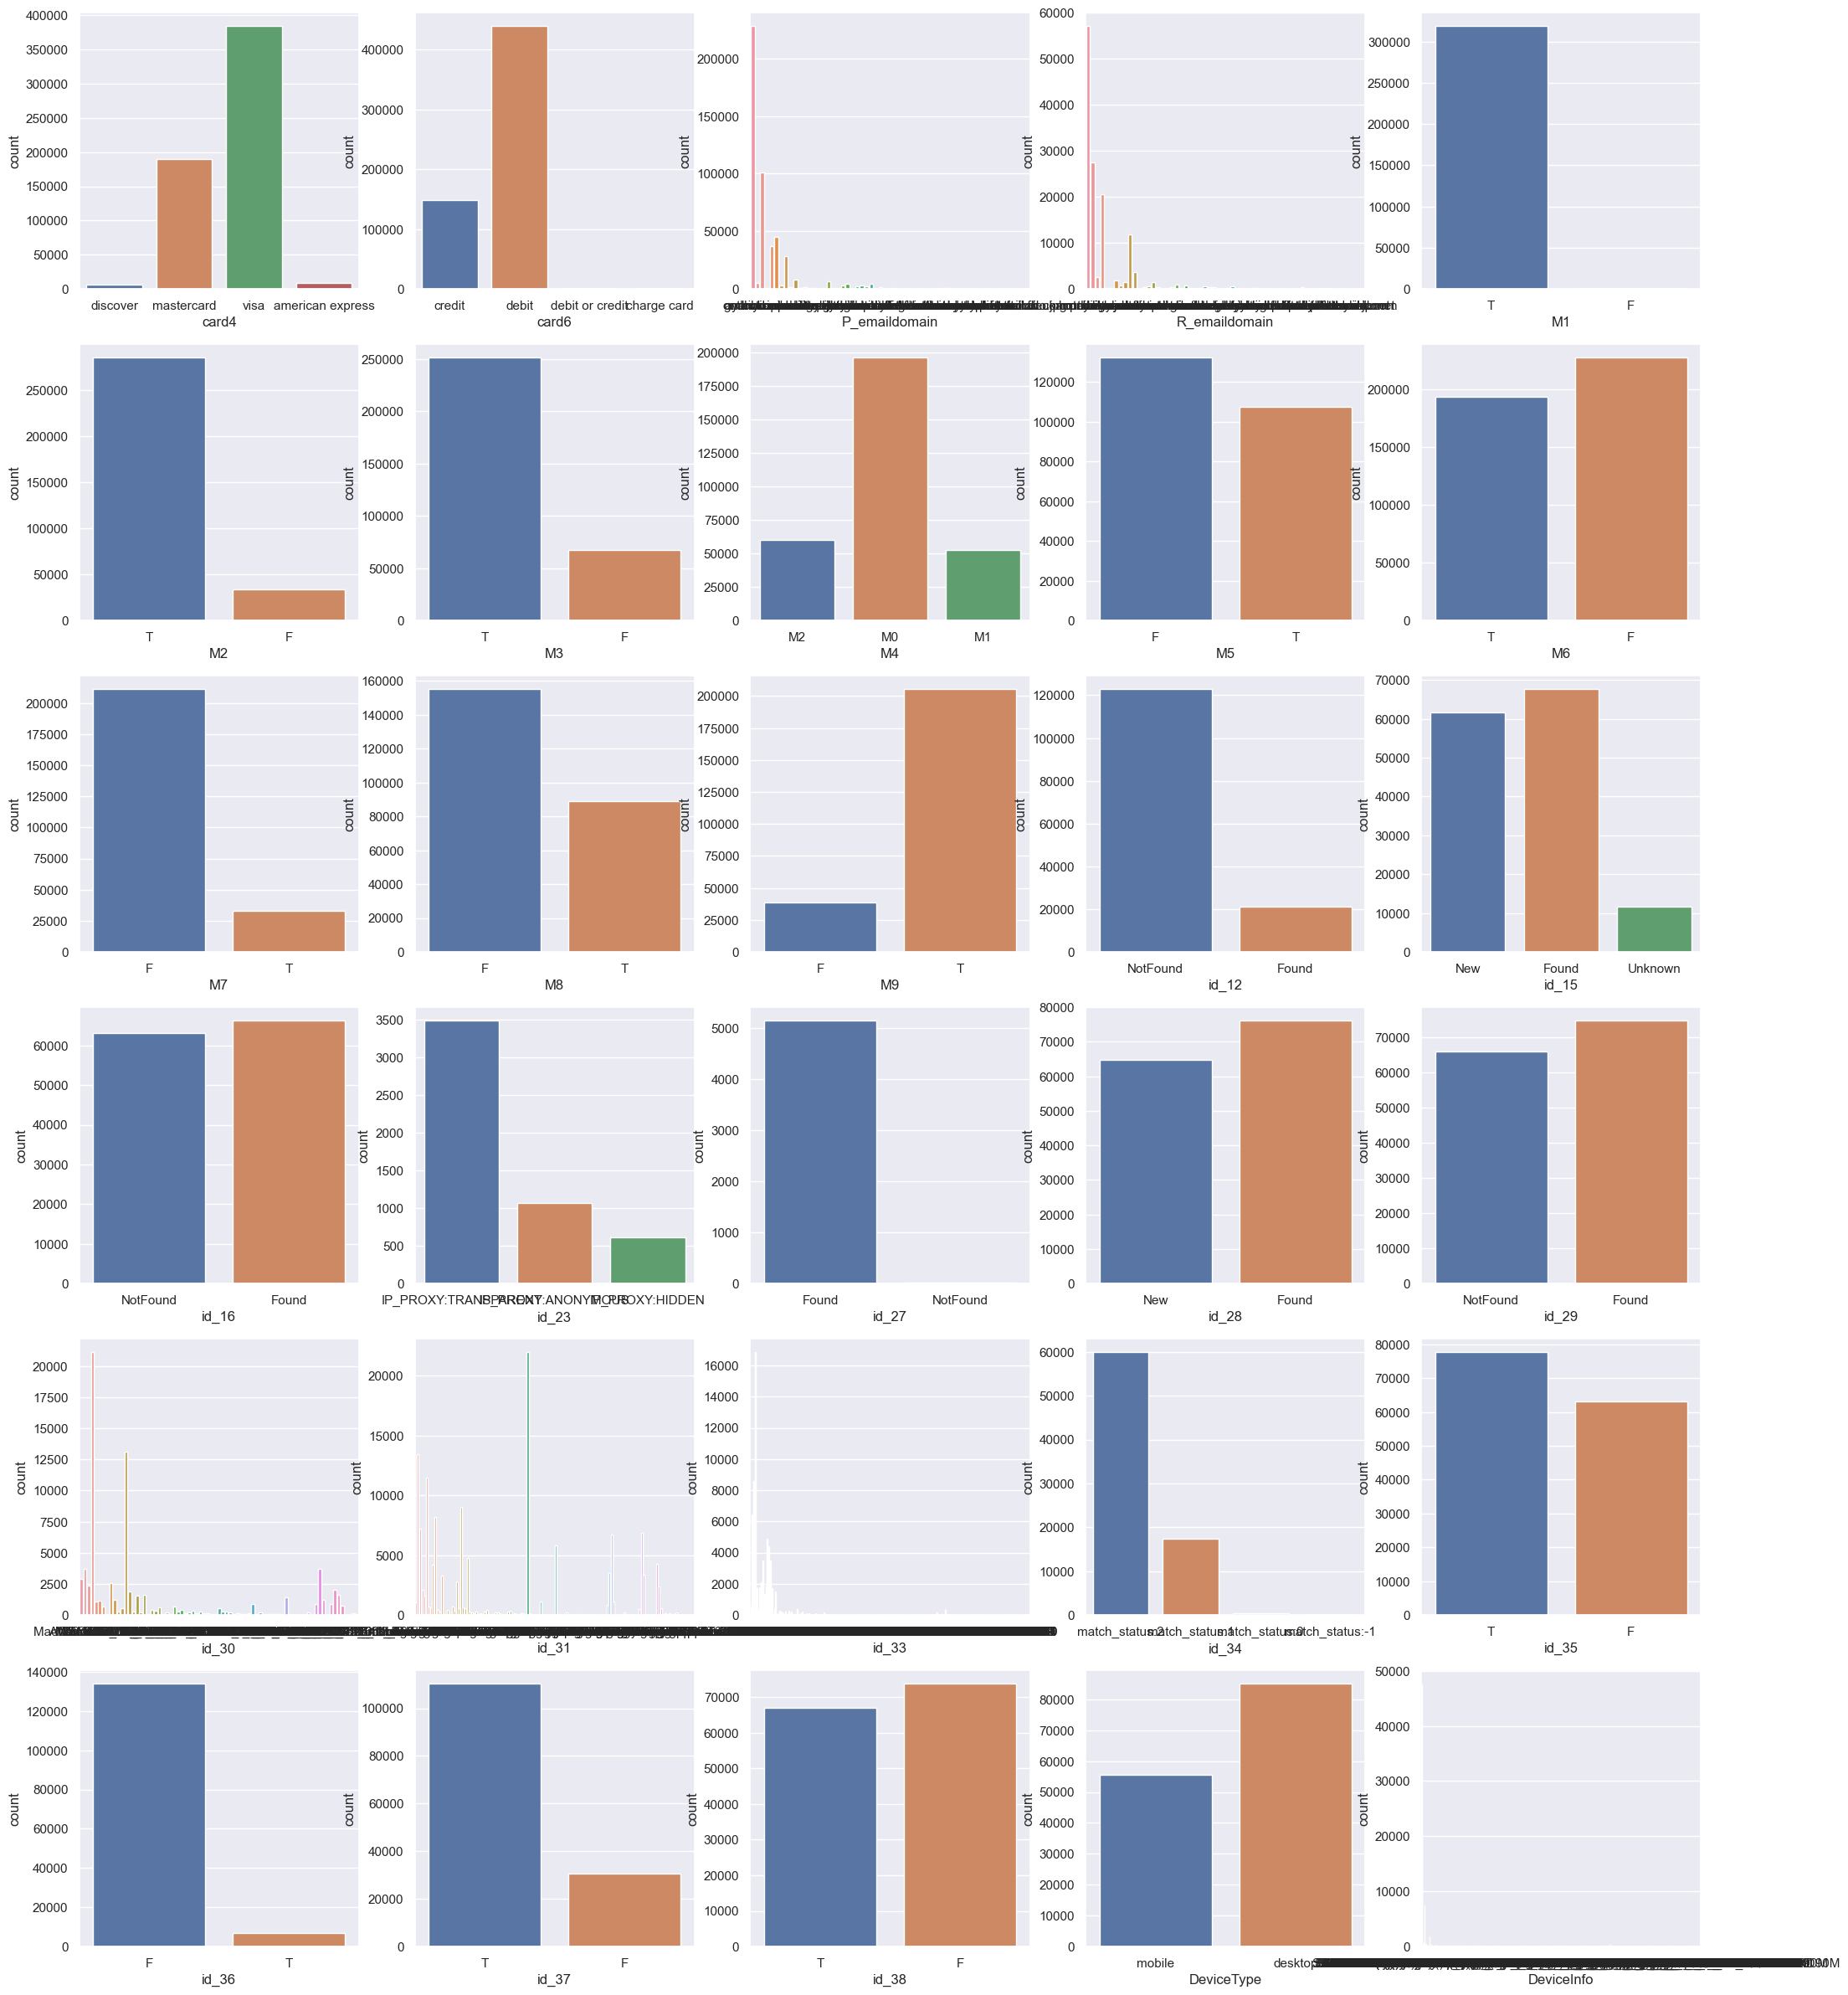

In [17]:
categorical_columns = df_train.select_dtypes(exclude=np.number).columns.to_list()

fig, axes = plt.subplots(6, 5, figsize=(25, 30))

aux = 1

for row in axes:
    for column in row:
        
        sns.countplot(data=df_train, x=categorical_columns[aux], ax=column)
        aux += 1


plt.show()

## Feature Engineering

### P_emaildomain

In [18]:
df_train['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [19]:
# Reagrupando os domínios de e-mail (df_train)
df_train.loc[df_train['P_emaildomain'].isin(['gmail','gmail.com']), 'P_emaildomain'] = 'Gmail'

df_train.loc[df_train['P_emaildomain'].isin(['yahoo.com', 'ymail.com',
       'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de',
       'yahoo.es', 'yahoo.fr']), 'P_emaildomain'] = 'Yahoo'

df_train.loc[df_train['P_emaildomain'].isin(['outlook.com', 'outlook.es',
       'hotmail.com', 'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'hotmail.fr',
       'msn.com', 'live.com','live.fr', 'live.com.mx']),'P_emaildomain'] = 'Microsoft'

df_train.loc[df_train['P_emaildomain'].isin(['mail.com', 'anonymous.com',
       'verizon.net', 'aol.com', 'me.com', 'comcast.net', 'optonline.net',
       'cox.net', 'charter.net', 'rocketmail.com', 'prodigy.net.mx',
       'embarqmail.com', 'icloud.com', 'att.net', 'juno.com',
       'sbcglobal.net', 'bellsouth.net', 'q.com', 'centurylink.net',
       'servicios-ta.com', 'earthlink.net', 'cfl.rr.com',
       'roadrunner.com', 'netzero.net', 'gmx.de', 'suddenlink.net',
       'frontiernet.net', 'windstream.net', 'frontier.com', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'sc.rr.com', 'ptd.net', 'protonmail.com']), 'P_emaildomain'] = 'Others'

# Reagrupando os domínios de e-mail (df_test)
df_test.loc[df_test['P_emaildomain'].isin(['gmail','gmail.com']), 'P_emaildomain'] = 'Gmail'

df_test.loc[df_test['P_emaildomain'].isin(['yahoo.com', 'ymail.com',
       'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de',
       'yahoo.es', 'yahoo.fr']), 'P_emaildomain'] = 'Yahoo'

df_test.loc[df_test['P_emaildomain'].isin(['outlook.com', 'outlook.es',
       'hotmail.com', 'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'hotmail.fr',
       'msn.com', 'live.com','live.fr', 'live.com.mx']),'P_emaildomain'] = 'Microsoft'

df_test.loc[df_test['P_emaildomain'].isin(['mail.com', 'anonymous.com',
       'verizon.net', 'aol.com', 'me.com', 'comcast.net', 'optonline.net',
       'cox.net', 'charter.net', 'rocketmail.com', 'prodigy.net.mx',
       'embarqmail.com', 'icloud.com', 'att.net', 'juno.com',
       'sbcglobal.net', 'bellsouth.net', 'q.com', 'centurylink.net',
       'servicios-ta.com', 'earthlink.net', 'cfl.rr.com',
       'roadrunner.com', 'netzero.net', 'gmx.de', 'suddenlink.net',
       'frontiernet.net', 'windstream.net', 'frontier.com', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'sc.rr.com', 'ptd.net', 'protonmail.com']), 'P_emaildomain'] = 'Others'

In [20]:
df_train['P_emaildomain'].value_counts(normalize=True)

Gmail        0.461315
Yahoo        0.212273
Others       0.206519
Microsoft    0.119893
Name: P_emaildomain, dtype: float64

### R_emaildomain

In [21]:
df_train['R_emaildomain'].unique()

array([nan, 'gmail.com', 'hotmail.com', 'outlook.com', 'anonymous.com',
       'charter.net', 'prodigy.net.mx', 'comcast.net', 'live.com.mx',
       'icloud.com', 'yahoo.com', 'aol.com', 'juno.com', 'att.net',
       'verizon.net', 'yahoo.com.mx', 'bellsouth.net', 'servicios-ta.com',
       'ymail.com', 'hotmail.es', 'msn.com', 'optonline.net', 'live.com',
       'gmx.de', 'aim.com', 'mail.com', 'me.com', 'outlook.es', 'cox.net',
       'earthlink.net', 'embarqmail.com', 'web.de', 'sbcglobal.net',
       'scranton.edu', 'mac.com', 'twc.com', 'roadrunner.com', 'yahoo.fr',
       'yahoo.de', 'yahoo.es', 'frontiernet.net', 'gmail', 'live.fr',
       'q.com', 'yahoo.co.uk', 'windstream.net', 'suddenlink.net',
       'hotmail.fr', 'ptd.net', 'hotmail.de', 'frontier.com',
       'cfl.rr.com', 'hotmail.co.uk', 'netzero.com', 'netzero.net',
       'yahoo.co.jp', 'rocketmail.com', 'centurylink.net',
       'protonmail.com', 'cableone.net', 'sc.rr.com'], dtype=object)

In [22]:
# Reagrupando os domínios de e-mail (df_train)
df_train.loc[df_train['R_emaildomain'].isin(['gmail','gmail.com']), 'R_emaildomain'] = 'Gmail'

df_train.loc[df_train['R_emaildomain'].isin(['yahoo.com', 'ymail.com',
       'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de',
       'yahoo.es', 'yahoo.fr']), 'R_emaildomain'] = 'Yahoo'

df_train.loc[df_train['R_emaildomain'].isin(['outlook.com', 'outlook.es',
       'hotmail.com', 'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'hotmail.fr',
       'msn.com', 'live.com','live.fr', 'live.com.mx']),'R_emaildomain'] = 'Microsoft'

df_train.loc[df_train['R_emaildomain'].isin(['mail.com', 'anonymous.com',
       'verizon.net', 'aol.com', 'me.com', 'comcast.net', 'optonline.net',
       'cox.net', 'charter.net', 'rocketmail.com', 'prodigy.net.mx',
       'embarqmail.com', 'icloud.com', 'att.net', 'juno.com',
       'sbcglobal.net', 'bellsouth.net', 'q.com', 'centurylink.net',
       'servicios-ta.com', 'earthlink.net', 'cfl.rr.com',
       'roadrunner.com', 'netzero.net', 'gmx.de', 'suddenlink.net',
       'frontiernet.net', 'windstream.net', 'frontier.com', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'sc.rr.com', 'ptd.net', 'protonmail.com', 'scranton.edu']), 'R_emaildomain'] = 'Others'

# Reagrupando os domínios de e-mail (df_test)
df_test.loc[df_test['R_emaildomain'].isin(['gmail','gmail.com']), 'R_emaildomain'] = 'Gmail'

df_test.loc[df_test['R_emaildomain'].isin(['yahoo.com', 'ymail.com',
       'yahoo.com.mx', 'yahoo.co.uk', 'yahoo.co.jp', 'yahoo.de',
       'yahoo.es', 'yahoo.fr']), 'R_emaildomain'] = 'Yahoo'

df_test.loc[df_test['R_emaildomain'].isin(['outlook.com', 'outlook.es',
       'hotmail.com', 'hotmail.es', 'hotmail.co.uk', 'hotmail.de', 'hotmail.fr',
       'msn.com', 'live.com','live.fr', 'live.com.mx']),'R_emaildomain'] = 'Microsoft'

df_test.loc[df_test['R_emaildomain'].isin(['mail.com', 'anonymous.com',
       'verizon.net', 'aol.com', 'me.com', 'comcast.net', 'optonline.net',
       'cox.net', 'charter.net', 'rocketmail.com', 'prodigy.net.mx',
       'embarqmail.com', 'icloud.com', 'att.net', 'juno.com',
       'sbcglobal.net', 'bellsouth.net', 'q.com', 'centurylink.net',
       'servicios-ta.com', 'earthlink.net', 'cfl.rr.com',
       'roadrunner.com', 'netzero.net', 'gmx.de', 'suddenlink.net',
       'frontiernet.net', 'windstream.net', 'frontier.com', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'sc.rr.com', 'ptd.net', 'protonmail.com', 'scranton.edu']), 'R_emaildomain'] = 'Others'

In [23]:
df_train['R_emaildomain'].value_counts(normalize=True)

Gmail        0.416939
Microsoft    0.244765
Others       0.237066
Yahoo        0.101230
Name: R_emaildomain, dtype: float64

## Splitting data